In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

In [3]:
df_train = pd.read_csv("../input/train.csv", parse_dates=['timestamp'])
df_test = pd.read_csv("../input/test.csv", parse_dates=['timestamp'])
df_macro = pd.read_csv("../input/macro.csv", parse_dates=['timestamp'])

df_train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


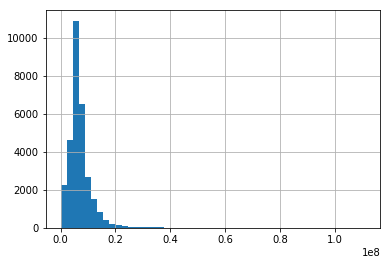

In [4]:
df_train['price_doc'].hist(bins=50)

In [5]:
y_train = df_train['price_doc'].values
id_test = df_test['id']

df_train.drop(['id', 'price_doc'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
df_all = df_all.join(df_macro, on='timestamp', rsuffix='_macro')
print(df_all.shape)

# Grouped features by time seems promising
# Count number of offers of this month
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Count number of offers of this week
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)     # relative floor in an apartment
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float) # relative kitchen_sq of a house

# Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp', 'timestamp_macro'], axis=1, inplace=True)

(38133, 390)


In [25]:
# Deal with categorical values
df_obj = df_all.select_dtypes(include=['object'])
df_numeric = df_all.select_dtypes(exclude=['object'])

factorize = lambda t: pd.factorize(t[1])[0]

X_all = np.c_[df_numeric.values,
              np.array(list(map(factorize, df_obj.iteritems()))).T]

print(X_all.shape)

(38133, 394)


In [26]:
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

print(df_values.shape)

(38133, 394)


In [27]:
# Convert to numpy values
X_all = df_values.values

#Split X_all to train and test
X_train = X_all[:num_train]
X_test = X_all[num_train:]

df_columns = df_values.columns

In [28]:
xgb_params = {
    'eta': 0.05,                # 学习率（0.01-0.2）
    'max_depth': 5,             # 树最大深度，避免过拟合（3-10）
    'subsample': 0.7,           # 对于每棵树随机采样的比例，减小该参数避免过拟合（0.5-1）
    'colsample_bytree': 0.7,    # 每棵树随机采样的列数的占比，每一列是一个特征（0.5-1）
    'objective': 'reg:linear',  # 损失函数
    'eval_metric': 'rmse',      # 度量方法
    'silent': 1                 # 不输出信息
}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

In [29]:
# Tune XGB `num_boost_rounds`

#cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
#    verbose_eval=True, show_stdv=False)
#cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
#num_boost_rounds = len(cv_result)

num_boost_round = 489   # Number of boosting iterations

In [30]:
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_round)

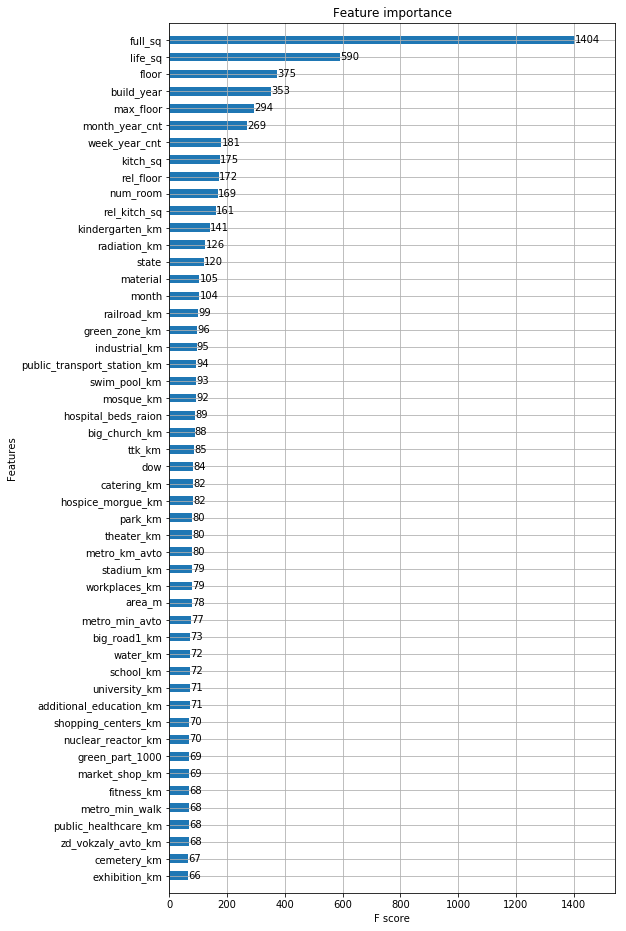

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [33]:
y_pred = model.predict(dtest)

df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

#df_sub.to_csv('sub_v9.csv', index=False)

df_sub.head()

,id,price_doc
0,30474,5469203.5
1,30475,8191015.5
2,30476,5353234.0
3,30477,5915246.5
4,30478,5144602.0
